# py_cartpole.ipynb

## Lecture 12 of CMU16-745 (2025)
Differential Dynamic Programming (cartpole)
Created: Apr 12, 25

**Note :** The original Julia notebook uses cartpole dynamics from RobotZoo.jl.
Here we substitute it with a function from 
R. Tedrake. [Underactuated Robotics: Algorithms for Walking, Running, Swimming, Flying, and Manipulation (Course Notes for MIT 6.832)](https://underactuated.csail.mit.edu). 2023.

If you want to use JAX for autodiff computation. Set this variable 
```python
use_jax = True 
```
Otherwise, Drake is used.

JAX is terribly slow, but can handle both DDP (full Newton) and iLQR (Gauss-Newton). 
Drake can handle only iLQR, because I still couldn't 
find a way to compute Hessian terms with Drake's forwarddiff. 

From my experiment, DDP is too slow to be practical! 


In [174]:
use_jax = False

In [49]:
# This variable is used to switch between normal and autodiff mode,
# because it seems like jax.numpy is quite slow, so we want to use
# numpy when not computing autodiff
# The vaiable is set and reset in some cells throughout the notebook
ad_flag = False  

In [175]:
import numpy as np 
from numpy import kron
import matplotlib.pyplot as plt 
from scipy.linalg import block_diag
if use_jax:
    import jax
    import jax.numpy as jnp
    from jax. numpy.linalg import solve, eigvals
else:
    from numpy.linalg import solve
    from pydrake import forwarddiff
    from pydrake.autodiffutils import AutoDiffXd, ExtractGradient, ExtractValue, InitializeAutoDiff    

In [50]:
# function that given the cart-pole state x (4d array)
# and the input u (1d array) returns the right
# hand side of the state space dynamics h(x,u)
# (remember that we fixed the cart-pole parameters
# to the values above!)
def cartpole(x, u):
    if use_jax and ad_flag:
        c = jnp.cos(x[1])  # cos(theta)
        s = jnp.sin(x[1])  # sin(theta)
    else:
        c = np.cos(x[1])  # cos(theta)
        s = np.sin(x[1])  # sin(theta)    
        
        
    # parameters. Changed to match RobotZoo's cartpole
    m_c = 1.0  # cart mass
    m_p = 0.2 # pendulum mass
    l = 0.5  # pole length
    g = 9.81  # gravity

    f1 = x[2]  # x_dot is the 3rd element of state vector
    f2 = x[3]  # theta_dot is the 4th element of state vector
    f3 = (1/(m_c + m_p*s**2))*(u + m_p*s*(l*x[3]**2+g*c))  # from (16) of [3]
    f4 = (1/(l*(m_c + m_p*s**2)))*(-u*c - m_p*l*x[3]**2*c*s - (m_c+m_p)*g*s)  # from (17) of [3]
    if use_jax and ad_flag:
        y = jnp.array([f1, f2, f3, f4]).reshape(4,1)
    else:
        y = np.array([f1, f2, f3, f4]).reshape(4,1)
        
    return y

In [28]:
h = 0.05 # time step

In [14]:
def cartpole_rk4(x,u):
    global f1, f2, f3, f4, ft,x_1,x_a
    #RK4 integration with zero-order hold on u
    x_1 = x
    f1 = cartpole(x, u)
    
    x_a = x.reshape(4,1)
    x_2 = x_a + 0.5*h*f1
    f2 = cartpole(x_2.flatten(), u)
    
    x_3 = x_a + 0.5*h*f2
    f3 = cartpole(x_3.flatten(), u)

    x_4 = x_a + 0.5*h*f3
    f4 = cartpole(x_4.flatten(), u)

    ft = x_a + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
    
    return ft

In [26]:
# for DDP use_jax
# convert [m,n,p] tensor to [m*n,p] matrix
def tensor2mat(Mat3d):
    dim3 = Mat3d.shape[2]
    M = Mat3d[:,:,0]
    for i in range(dim3-1):
        M = jnp.vstack((M,Mat3d[:,:,i+1]))

    return M

In [79]:
# turn matrix to vector column-wise. Does not work with jax.jacfwd!
# def vec(Mat):
#     nrows = Mat.shape[0]
#     ncols = Mat.shape[1]
#     V = Mat[:,[0]]
#     for i in range(ncols-1):
#         V = jnp.vstack((V,Mat[:,[i+1]]))
#     return V

In [16]:
# For DDP use_jax
def vec(Mat):
    global M_global
    M_global = Mat
    m, n = jnp.shape(Mat)[0], jnp.shape(Mat)[1]
    return jnp.reshape(Mat,(m*n,1), order='F')

In [89]:
# for DDP use_jax
from scipy.sparse import csr_matrix
def comm(M):
    m, n = M.shape[0], M.shape[1]
    row  = np.arange(m*n)
    col  = row.reshape((m, n), order='F').ravel()
    data = np.ones(m*n, dtype=np.int8)
    T = csr_matrix((data, (row, col)), shape=(m*n, m*n))
    return T.toarray()

# this commutation matrix is constant. So just compute it once
Amat = np.zeros((Nx,Nx))
commA = comm(Amat)



In [18]:
#vec(A)

In [19]:
# For DDP use_jax
def is_pos_def(x):
    return np.all(eigvals(x) > 0)

In [129]:
# mymat = np.array([[-1, 0],[0,1]])

In [20]:
# is_pos_def(mymat)

In [21]:
# comm(A)

In [51]:
# wrapper for Drake
def cartpole_rk4_x(x):
    # global u_global 
    return cartpole_rk4(x, u_global)

def cartpole_rk4_u(u):
    # global x_global 
    return cartpole_rk4(x_global.flatten(), u)    
    

In [179]:
# slightly modified from Drake's forwarddiff.py to handle vector output
def vecout_derivative(function, x):
    """Compute the derivative of the function evaluated at the scalar input x
    using Eigen's automatic differentiation.

    The function should be scalar-input and vector-output.
    """
    x_ad = AutoDiffXd(value=x, size=1, offset=0)
    y_ad = function(x_ad)
    y_derivative = ExtractGradient(y_ad)
    return y_derivative


In [53]:
# use JAX
def dfdx(x,u):
    global u_global, ad_flag
    u_global = u
    if use_jax:
        ad_flag = True
        y = jnp.squeeze(jax.jacfwd(cartpole_rk4,argnums=0)(x,u))
        ad_flag = False
    else:
        y = np.squeeze(forwarddiff.jacobian(cartpole_rk4_x,x.flatten()))
    return y

def dfdu(x,u):
    global x_global, ad_flag
    x_global = x
    if use_jax:
        ad_flag = True
        y = jax.jacfwd(cartpole_rk4,argnums=1)(x,u)
        ad_flag = False
    else:
        y = vecout_derivative(cartpole_rk4_u,u)
    
    return y


In [54]:
# these functions are for DDP. use_jax must be set to True
def dAdx(x,u):
    global ad_flag
    ad_flag = True
    y = jax.jacfwd(dfdx)(x,u)
    ad_flag = False
    return tensor2mat(y)

def dBdx(x,u):
    global ad_flag
    ad_flag = True
    y = jax.jacfwd(dfdu)(x,u)
    ad_flag = False
    return jnp.squeeze(y)

def dAdu(x,u):
    global ad_flag
    ad_flag = True    
    y = jax.jacfwd(dfdu)(x,u)
    ad_flag = False
    return tensor2mat(y)

def dBdu(x,u):
    global ad_flag
    ad_flag = True    
    y = jax.jacfwd(dfdu,argnums=1)(x,u)
    ad_flag = False    
    return y
    

In [230]:
# ---------------- Jacobian test  
x_star = np.array([0, np.pi, 0, 0])
u_star = 0.0
A_test = dfdx(x_star,u_star)
A_test

array([[1.00000000e+00, 2.04976476e-03, 5.00000000e-02, 3.06562500e-05],
       [0.00000000e+00, 1.02459718e+00, 0.00000000e+00, 5.03678750e-02],
       [0.00000000e+00, 9.88217708e-02, 1.00000000e+00, 2.04976476e-03],
       [0.00000000e+00, 1.18586125e+00, 0.00000000e+00, 1.02459718e+00]])

In [109]:
B_test = dfdu(x_star,u_star)
B_test

Array([[0.00104218],
       [0.00208946],
       [0.05006131],
       [0.10073575]], dtype=float32)

In [ ]:
# the test cells below require use_jax = True

In [111]:
Ax_test = dAdx(x_star,u_star)
Ax_test.shape

(16, 4)

In [112]:
Bx_test = dBdx(x_star,u_star)
Bx_test

Array([[ 0.0000000e+00, -3.7477955e-11,  0.0000000e+00, -1.1120314e-12],
       [ 0.0000000e+00, -2.5897326e-10,  0.0000000e+00, -4.9738920e-12],
       [ 0.0000000e+00, -1.8405794e-09,  0.0000000e+00, -7.5036338e-11],
       [ 0.0000000e+00, -1.2650034e-08,  0.0000000e+00, -3.3570066e-10]],      dtype=float32)

In [59]:
Bx_test.shape

(4, 4)

In [113]:
Au_test = dAdu(x_star,u_star)
Au_test

Array([[ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [-3.7477955e-11],
       [-2.5897326e-10],
       [-1.8405794e-09],
       [-1.2650034e-08],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [-1.1120314e-12],
       [-4.9738920e-12],
       [-7.5036338e-11],
       [-3.3570066e-10]], dtype=float32)

In [61]:
Au_test.shape

(16, 1)

In [114]:
Bu_test = dBdu(x_star,u_star)
Bu_test

Array([[-4.6091047e-14],
       [-1.8414083e-13],
       [-4.0857296e-12],
       [-1.9215442e-11]], dtype=float32)

In [115]:
Bu_test.shape

(4, 1)

In [ ]:
# --------------- end of Jacobian test ----------------

In [39]:
h = 0.05  # time step. Defined above
Nx = 4     # number of state
Nu = 1     # number of controls
Tfinal = 5.0 # final time 
Nt = int(Tfinal/h)+1    # number of time steps
thist = np.arange(0,h*(Nt-1),h)

In [40]:
# Cost weights
Q = block_diag(1.0*np.eye(2), 1.0*np.eye(2))
R = 0.1
Qn = 100*np.eye(Nx) # large weight on terminal cost


In [41]:
def stage_cost(x,u):
    xbar = x-xgoal
    return 0.5*((xbar.T@Q@xbar) + R*u*u)    

In [42]:
def terminal_cost(x):
    xbar = x-xgoal
    return 0.5*xbar.T@Qn@xbar

In [43]:
def cost(xtraj, utraj):
    J = 0.0
    for k in range(Nt-1):
        J += stage_cost(xtraj[:,[k]],utraj[k])
    J += terminal_cost(xtraj[:,[Nt-1]])
    return J.item()

In [74]:
# forward rollout function
def initial_rollout():
    global xtraj, ad_flag
    ad_flag = False
    for k in range(Nt-1):
        xtraj[:,[k+1]] = cartpole_rk4(xtraj[:,k], utraj[k])
    J = cost(xtraj, utraj)
    return J   

In [186]:
# initial guess
x0 = np.array([0,0,0,0]).reshape(4,1)
xgoal = np.array([0,np.pi,0,0]).reshape(4,1)
xtraj = np.kron(np.ones((1,Nt)),x0)
utraj = np.random.rand(Nt-1)

In [187]:
J = initial_rollout()
J

3315.5731551867893

In [188]:
def backward_pass(mode='ilqr'):
    global p,P,d,K,gx,gu,Gxx,Gxu,Gux,Guu,G, k,A,B,Ax,Bx,Au,Bu
    dJ = 0.0
    p[:,[Nt-1]] = Qn@(xtraj[:,[Nt-1]]-xgoal)
    P[:,:,Nt-1] = Qn
    
    for k in range(Nt-2,-1,-1):
        # Calculate derivatives
        q  = Q@(xtraj[:,[k]] - xgoal)
        r = R*utraj[k]

        A = dfdx(xtraj[:,[k]], utraj[k])
        B = dfdu(xtraj[:,[k]], utraj[k])

        gx = q + A.T@p[:,[k+1]]
        gu = r + B.T@p[:,[k+1]]


        if mode=='ddp' and use_jax:
            # DDP (full Newron) version works only with JAX autodiff
            Ax = dAdx(xtraj[:,[k]], utraj[k])
            Bx = dBdx(xtraj[:,[k]], utraj[k])
            Au = dAdu(xtraj[:,[k]], utraj[k])
            Bu = dBdu(xtraj[:,[k]], utraj[k])
            Gxx = Q + A.T@P[:,:,k+1]@A + kron(p[:,[k+1]].T,np.eye(Nx))@commA@Ax[:,:,0]
            Guu = R + B.T@P[:,:,k+1]@B + (kron(p[:,[k+1]].T, np.eye(Nu))@Bu)[0]
            Gxu = A.T@P[:,:,k+1]@B + kron(p[:,[k+1]].T,np.eye(Nx))@commA@Au[:,:,0]
            Gux = B.T@P[:,:,k+1]@A + kron(p[:,[k+1]].T, np.eye(Nu))@Bu
    
            beta = 0.1
            G = np.block([[Gxx, Gxu],[Gux, Guu]])
            while not is_pos_def(G):
                Gxx += beta*np.eye(Gxx.shape[0])
                Guu += beta*np.eye(Guu.shape[0])
                beta = 2*beta
                print("regularizing G")
                print("beta = "+str(beta))
        else:  # default to ilqr mode
            # iLQR (Gauss-Newton) version 
            Gxx = Q + A.T@P[:,:,k+1]@A
            Guu = R + B.T@P[:,:,k+1]@B
            Gxu = A.T@P[:,:,k+1]@B
            Gux = B.T@P[:,:,k+1]@A
            
        d[k] = solve(Guu,gu).item()
        K[:,:,k] = solve(Guu,Gux)

        p[:,[k]] = gx - K[:,:,k].T@gu + K[:,:,k].T@Guu*d[k] - Gxu*d[k]
        P[:,:,k] = Gxx + K[:,:,k].T@Guu@K[:,:,k] - Gxu@K[:,:,k] - K[:,:,k].T@Gux

        dJ += (gu.T*d[k]).item()
    return dJ

In [164]:
# rollout with line search
def rollout_with_ls():
    global xtraj, xn, un, Jn, alpha, ad_flag
    ad_flag = False
    xn[:,[0]] = xtraj[:,[0]]
    alpha = 1.0
    for k in range(Nt-1):
        un[k] = (utraj[k] - alpha*d[k] - np.dot(K[:,:,k],xn[:,[k]]-xtraj[:,[k]])).item()
        xn[:,[k+1]] = cartpole_rk4(xn[:,[k]],un[k])

    Jn = cost(xn,un)
    
    while np.isnan(Jn) or Jn > (J - (1e-2)*alpha*dJ):
        alpha = 0.5*alpha
        # print("alpha = "+str(alpha))
        for k in range(Nt-1):
            un[k] = (utraj[k] - alpha*d[k] - np.dot(K[:,:,k],xn[:,[k]]-xtraj[:,[k]])).item()
            xn[:,[k+1]] = cartpole_rk4(xn[:,[k]],un[k])
        Jn = cost(xn,un)    

In [189]:
# DDP algorithm
p = np.zeros((Nx,Nt))
P = np.zeros((Nx, Nx, Nt))
d = np.ones((Nt-1))
K = np.zeros((Nu, Nx, Nt-1))
dJ = 0.0

xn = np.zeros((Nx,Nt))
un = np.zeros((Nt-1))

gx = np.zeros((Nx))
gu = 0.0
Gxx = np.zeros((Nx,Nx))
Guu = 0.0
Gxu = np.zeros((Nx))
Gux = np.zeros((Nx))

iter = 0
while np.max(abs(d)) >2e-2: #1e-3:
    iter+=1

    # Backward pass
    # dJ = backward_pass()
    dJ = backward_pass()
        
    # forward rollout with line search
    rollout_with_ls()

        
    # logging 
    if use_jax:  # jax is so slow, so print every iteration
        if (iter-1)%10 == 0:  # print heading every 10 iterations
            print("iter        J                  ΔJ                   |d|             α       ")
            print("-----------------------------------------------------------------------------")
        if (iter-1)%1 == 0: # print values every 1 iterations
            print("{}   {}    {}   {}    {} ".format(iter, J,
                                        dJ, np.max(abs(d)), alpha))
    else: # drake is faster. Print every 10 iterations
        if (iter-1)%100 == 0:  # print heading every 100 iterations
            print("iter        J                  ΔJ                   |d|             α       ")
            print("-----------------------------------------------------------------------------")
        if (iter-1)%10 == 0: # print values every 10 iterations
            print("{}   {}    {}   {}    {} ".format(iter, J,
                                        dJ, np.max(abs(d)), alpha))
        

    J = Jn
    xtraj = xn.copy()  # important! code xtraj = xn results in some bug difficult to find
    utraj = un.copy()

iter        J                  ΔJ                   |d|             α       
-----------------------------------------------------------------------------
1   3315.5731551867893    5102.575025409894   53.593510035406965    1.0 
11   723.8164233247724    1.1904330362051971   1.2088054565310558    1.0 
21   714.0721247132208    0.8200981193356548   1.0141623556423691    1.0 
31   706.3789557804688    0.7082211585582203   0.9385801577615251    1.0 
41   699.5278922898696    0.6536452742339681   0.9005486929719365    1.0 
51   693.0661954654046    0.6338875944174434   0.8801452489584903    1.0 
61   686.6912909182523    0.6376661106333353   0.8896491466768037    1.0 
71   680.2094812764931    0.6552599490546299   0.8856554254591482    1.0 
81   673.5183623302902    0.6788516099637534   0.9134943023973144    1.0 
91   666.5868847211677    0.7024508454008128   0.9233066522664395    1.0 
iter        J                  ΔJ                   |d|             α       
-----------------------------

In [218]:
# plot states and control
def plot_x():
    plt.figure()
    plt.plot(thist,xtraj[0,:-1],"b-",thist,xtraj[1,:-1],'orange')
    plt.xlabel("time (sec)")
    plt.ylabel("x(k)")
    plt.legend(["x","theta"])
    plt.grid(True)
    plt.show()

def plot_u():
    plt.plot(thist[0:Nt-1],utraj,"m-")
    plt.xlabel("time (sec)")
    plt.ylabel("u(k)")
    plt.grid(True)
    plt.show()

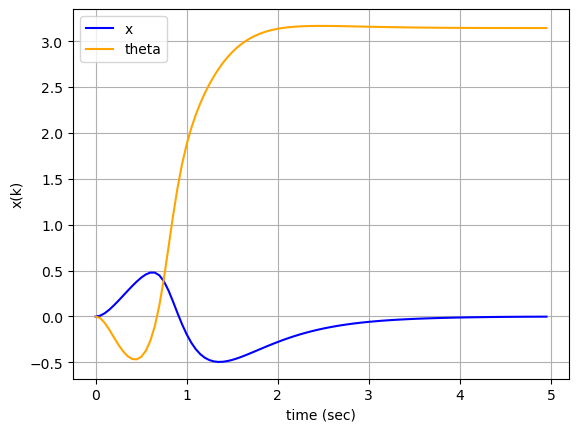

In [219]:
plot_x()

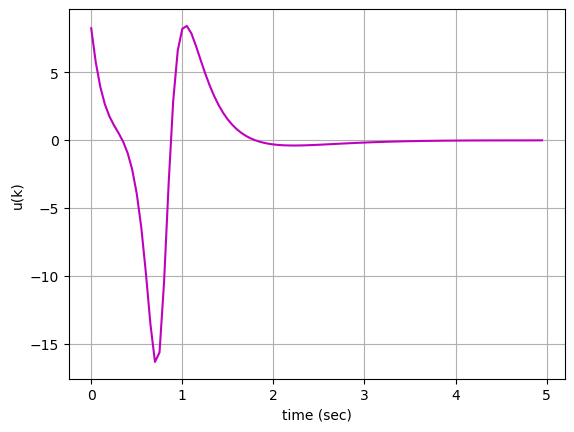

In [191]:
plot_u()

In [196]:
# meshcat animation
import meshcat
import meshcat.geometry as g
import meshcat.transformations as tf
#from meshcat.animation import Animation
import time

In [193]:
# Create a new visualizer
vis = meshcat.Visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [211]:
# create cartpole
def build_cartpole(vis):
    cart_pole = vis["cart_pole"]
    cart_pole.delete()
    cart = cart_pole["cart"]
    pivot = cart["pivot"]
    pole = pivot["pole"]
    cart.set_object(g.Box([0.5, 0.3, 0.2]))
    pole.set_object(g.Box([0.05, 0.05, 0.5]))
    pole.set_transform(tf.translation_matrix([0, 0, -0.25]))
    # pivot.set_transform(tf.rotation_matrix(-np.pi/2, [0, 1, 0]))
    return cart,pivot

In [212]:
cart_x, cart_th = build_cartpole(vis)

In [227]:
def initialize_cartpole():
    update_cartpole(0,0)
    

In [228]:
initialize_cartpole()

In [204]:
# update cartpole pose
def update_cartpole(x,th):
    cart_th.set_transform(tf.rotation_matrix(th,[0,1,0]))
    cart_x.set_transform(tf.translation_matrix([x, 0, 0]))

In [220]:
def simulate_cartpole():
    for k in range(xtraj.shape[1]):
        x = xtraj[0,k] # cart position
        th = xtraj[1,k] # pole angle
        update_cartpole(x,th)
        time.sleep(h)

In [229]:
simulate_cartpole()